In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
from scipy import stats
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from numpy import percentile

from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE

sns.set()

    Filter out data using SQL propertylandusetypeid = 261 and transactiondate 2017

In [2]:
df = acquire.get_zillow_data()

Reading from csv file...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52441 non-null  int64  
 1   bedroomcnt                    52441 non-null  float64
 2   bathroomcnt                   52441 non-null  float64
 3   calculatedfinishedsquarefeet  52359 non-null  float64
 4   poolcnt                       11096 non-null  float64
 5   pooltypeid2                   1071 non-null   float64
 6   pooltypeid10                  444 non-null    float64
 7   fireplacecnt                  7243 non-null   float64
 8   garagecarcnt                  18015 non-null  float64
 9   numberofstories               14561 non-null  float64
 10  yearbuilt                     52325 non-null  float64
 11  lotsizesquarefeet             52072 non-null  float64
 12  latitude                      52441 non-null  float64
 13  l

    Verify there are no duplicates in df. Yay no duplicates

In [4]:
df.duplicated().sum()

0

    How many NaN values in df

In [5]:
df_prep = df.copy(deep=True)
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       82
poolcnt                         41345
pooltypeid2                     51370
pooltypeid10                    51997
fireplacecnt                    45198
garagecarcnt                    34426
numberofstories                 37880
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

In [6]:
df_prep.bathroomcnt.value_counts()

2.0     21893
3.0     10673
1.0      9568
2.5      3934
4.0      2227
3.5       918
1.5       841
5.0       803
4.5       687
6.0       322
5.5       224
0.0       121
7.0        88
8.0        53
6.5        47
7.5        16
9.0        13
10.0        5
11.0        3
8.5         3
18.0        1
13.0        1
Name: bathroomcnt, dtype: int64

In [7]:
df_prep.bedroomcnt.value_counts()

3.0     23359
4.0     15240
2.0      8340
5.0      3973
6.0       635
1.0       612
0.0       137
7.0       106
8.0        24
9.0         8
12.0        3
10.0        2
14.0        1
11.0        1
Name: bedroomcnt, dtype: int64

    Replace zero values in bath & bed with NaN

In [8]:
bed_bath_0_columns = ['bedroomcnt', 'bathroomcnt']
df_prep[bed_bath_0_columns] = df_prep[bed_bath_0_columns].replace(0, np.NaN)
df_prep = df_prep.reset_index(drop=True)

In [9]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                         41345
pooltypeid2                     51370
pooltypeid10                    51997
fireplacecnt                    45198
garagecarcnt                    34426
numberofstories                 37880
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    Since all fire/pool/gareage that NaN are 0 we will replace NaN values with 0 for pool, fire, and garage

In [10]:
fire_garge_pool_0_columns = ['poolcnt','pooltypeid2','pooltypeid10', 'fireplacecnt','garagecarcnt']
df_prep[fire_garge_pool_0_columns] = df_prep[fire_garge_pool_0_columns].replace(np.NaN, 0)
df_prep = df_prep.reset_index(drop=True)


In [11]:
df_prep.isnull().sum()

parcelid                            0
bedroomcnt                        137
bathroomcnt                       121
calculatedfinishedsquarefeet       82
poolcnt                             0
pooltypeid2                         0
pooltypeid10                        0
fireplacecnt                        0
garagecarcnt                        0
numberofstories                 37880
yearbuilt                         116
lotsizesquarefeet                 369
latitude                            0
longitude                           0
regionidcounty                      0
regionidzip                        26
fips                                0
taxvaluedollarcnt                   1
transactiondate                     0
propertylandusetypeid               0
dtype: int64

    There is 37880 NaN values in column numberofstories which is 72% of the dataset. I will be dropping this column for the sake of time and inputing them most likely will negatively effect the model.

In [12]:
df_prep = df_prep.drop(columns='numberofstories', axis=1)

In [13]:
df_prep.shape

(52441, 19)

    Since there are only 558 unique rows that contain NaN values we are going to drop all for the sake of time

In [14]:
df_prep = df_prep.dropna(axis=0)
df_prep = df_prep.reset_index(drop=True)

In [15]:
df_prep.shape

(51883, 19)

In [16]:
df_prep.head(10)

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,poolcnt,pooltypeid2,pooltypeid10,fireplacecnt,garagecarcnt,yearbuilt,lotsizesquarefeet,latitude,longitude,regionidcounty,regionidzip,fips,taxvaluedollarcnt,transactiondate,propertylandusetypeid
0,14297519,4.0,3.5,3100.0,0.0,0.0,0.0,0.0,2.0,1998.0,4506.0,33634931.0,-117869207.0,1286.0,96978.0,6059.0,1023282.0,2017-01-01,261.0
1,17052889,2.0,1.0,1465.0,0.0,0.0,0.0,1.0,1.0,1967.0,12647.0,34449266.0,-119281531.0,2061.0,97099.0,6111.0,464000.0,2017-01-01,261.0
2,14186244,3.0,2.0,1243.0,1.0,0.0,0.0,0.0,2.0,1962.0,8432.0,33886168.0,-117823170.0,1286.0,97078.0,6059.0,564778.0,2017-01-01,261.0
3,12177905,4.0,3.0,2376.0,1.0,0.0,0.0,0.0,0.0,1970.0,13038.0,34245180.0,-118240722.0,3101.0,96330.0,6037.0,145143.0,2017-01-01,261.0
4,12095076,4.0,3.0,2962.0,1.0,0.0,0.0,0.0,0.0,1950.0,63000.0,34145202.0,-118179824.0,3101.0,96293.0,6037.0,773303.0,2017-01-01,261.0
5,12069064,2.0,1.0,738.0,0.0,0.0,0.0,0.0,0.0,1922.0,4214.0,34149214.0,-118239357.0,3101.0,96325.0,6037.0,218552.0,2017-01-01,261.0
6,12790562,4.0,3.0,3039.0,0.0,0.0,0.0,0.0,0.0,1970.0,20028.0,33960230.0,-118006914.0,3101.0,96173.0,6037.0,220583.0,2017-01-02,261.0
7,11104527,4.0,3.0,2540.0,1.0,0.0,0.0,0.0,0.0,1999.0,10384.0,34434971.0,-118464390.0,3101.0,96374.0,6037.0,430108.0,2017-01-02,261.0
8,13944538,3.0,2.5,1340.0,0.0,0.0,0.0,1.0,2.0,1980.0,1199.0,33771438.0,-117982834.0,1286.0,97051.0,6059.0,319668.0,2017-01-02,261.0
9,17110996,3.0,2.5,1371.0,0.0,0.0,0.0,0.0,2.0,2004.0,3445.0,34238229.0,-119170633.0,2061.0,97107.0,6111.0,198054.0,2017-01-02,261.0


In [17]:
df_prep.columns

Index(['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'poolcnt', 'pooltypeid2', 'pooltypeid10', 'fireplacecnt',
       'garagecarcnt', 'yearbuilt', 'lotsizesquarefeet', 'latitude',
       'longitude', 'regionidcounty', 'regionidzip', 'fips',
       'taxvaluedollarcnt', 'transactiondate', 'propertylandusetypeid'],
      dtype='object')

In [18]:
df_prep.columns

Index(['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'poolcnt', 'pooltypeid2', 'pooltypeid10', 'fireplacecnt',
       'garagecarcnt', 'yearbuilt', 'lotsizesquarefeet', 'latitude',
       'longitude', 'regionidcounty', 'regionidzip', 'fips',
       'taxvaluedollarcnt', 'transactiondate', 'propertylandusetypeid'],
      dtype='object')

In [19]:
df_prep = df_prep.drop(columns=['parcelid', 'propertylandusetypeid', 'transactiondate'])

In [20]:
df_prep.columns

Index(['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'poolcnt',
       'pooltypeid2', 'pooltypeid10', 'fireplacecnt', 'garagecarcnt',
       'yearbuilt', 'lotsizesquarefeet', 'latitude', 'longitude',
       'regionidcounty', 'regionidzip', 'fips', 'taxvaluedollarcnt'],
      dtype='object')

In [21]:
df_prep = df_prep.rename(columns={'bedroomcnt':'bedrooms', 'bathroomcnt':'bathrooms', 'calculatedfinishedsquarefeet':'sqft_living', 'poolcnt':'pools', 'pooltypeid2':'pool_hottub_or_spa', 'pooltypeid10':'hottub_or_spa', 'fireplacecnt':'fireplaces', 'garagecarcnt':'garage_cars', 'yearbuilt':'year_built', 'lotsizesquarefeet':'sqft_lot', 'latitude':'lat', 'longitude':'long', 'regionidcounty':'countyid', 'regionidzip':'zip', 'fips':'fips','taxvaluedollarcnt': 'taxvalue'})

In [22]:
df_prep.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'pools', 'pool_hottub_or_spa',
       'hottub_or_spa', 'fireplaces', 'garage_cars', 'year_built', 'sqft_lot',
       'lat', 'long', 'countyid', 'zip', 'fips', 'taxvalue'],
      dtype='object')

In [23]:
df_prep.head(10)

,bedrooms,bathrooms,sqft_living,pools,pool_hottub_or_spa,hottub_or_spa,fireplaces,garage_cars,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
0,4.0,3.5,3100.0,0.0,0.0,0.0,0.0,2.0,1998.0,4506.0,33634931.0,-117869207.0,1286.0,96978.0,6059.0,1023282.0
1,2.0,1.0,1465.0,0.0,0.0,0.0,1.0,1.0,1967.0,12647.0,34449266.0,-119281531.0,2061.0,97099.0,6111.0,464000.0
2,3.0,2.0,1243.0,1.0,0.0,0.0,0.0,2.0,1962.0,8432.0,33886168.0,-117823170.0,1286.0,97078.0,6059.0,564778.0
3,4.0,3.0,2376.0,1.0,0.0,0.0,0.0,0.0,1970.0,13038.0,34245180.0,-118240722.0,3101.0,96330.0,6037.0,145143.0
4,4.0,3.0,2962.0,1.0,0.0,0.0,0.0,0.0,1950.0,63000.0,34145202.0,-118179824.0,3101.0,96293.0,6037.0,773303.0
5,2.0,1.0,738.0,0.0,0.0,0.0,0.0,0.0,1922.0,4214.0,34149214.0,-118239357.0,3101.0,96325.0,6037.0,218552.0
6,4.0,3.0,3039.0,0.0,0.0,0.0,0.0,0.0,1970.0,20028.0,33960230.0,-118006914.0,3101.0,96173.0,6037.0,220583.0
7,4.0,3.0,2540.0,1.0,0.0,0.0,0.0,0.0,1999.0,10384.0,34434971.0,-118464390.0,3101.0,96374.0,6037.0,430108.0
8,3.0,2.5,1340.0,0.0,0.0,0.0,1.0,2.0,1980.0,1199.0,33771438.0,-117982834.0,1286.0,97051.0,6059.0,319668.0
9,3.0,2.5,1371.0,0.0,0.0,0.0,0.0,2.0,2004.0,3445.0,34238229.0,-119170633.0,2061.0,97107.0,6111.0,198054.0


In [24]:
eda = df_prep.copy(deep=True)

    EDA

    split data

In [25]:
train_and_validate, test = train_test_split(eda, random_state=123, test_size=.2)
train, validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [26]:
def corrstatsgraphs3(df):
    """
    Description
    ----
    Outputs the general statistical description of the dataframe,
    outputs the correlation heatmap with target label, and outputs a distribution plot.
    
    Parameters
    ----
    df(DataFrame):
        The dataframe for which information will be displayed.
        
    Returns
    ----
    useful stats, correlation, and subplots
    
    """
       
    # Heatmap with min -1 to max 1 to all variables
    # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    corr = df.corr()
    plt.subplots(figsize=(22, 17))
    plt.title("Heatmap", fontsize = 'x-large')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 21, as_cmap=True)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, vmin=-1, vmax=1
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr 
    plt.figure(figsize=(10, 8)) 
    plt.title("Heatmap", fontsize = 'x-large')
    sns.heatmap(df.corr()[['taxvalue']].sort_values(by='taxvalue', 
    ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG'
    )
    sns.pairplot(df[['bedrooms', 'bathrooms', 'sqft_living', 'pools', 'pool_hottub_or_spa',
       'hottub_or_spa', 'fireplaces', 'garage_cars', 'year_built', 'sqft_lot',
       'countyid', 'zip', 'fips', 'taxvalue']], corner=True, kind='reg', plot_kws={'line_kws':{'color':'red'}}
    )
    # Correlation Heatmap with min -1 to max 1 in conjuction with pd.corr
    plt.figure(figsize=(16,10))
    df.corr()['taxvalue'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5), cmap='BrBG'
    )
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='reg', height=5, line_kws={'color': 'red'}
    )
    sns.jointplot(x="bedrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'}
    )
      
    sns.jointplot(x="bathrooms", y="taxvalue", data=df, ratio=5, kind='reg', height=5, line_kws={'color': 'red'}
    )
    sns.jointplot(x="bathrooms", y="taxvalue", data=df,  kind='kde', line_kws={'color': 'red'})

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(
/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'line_kws'
  cset = contour_func(


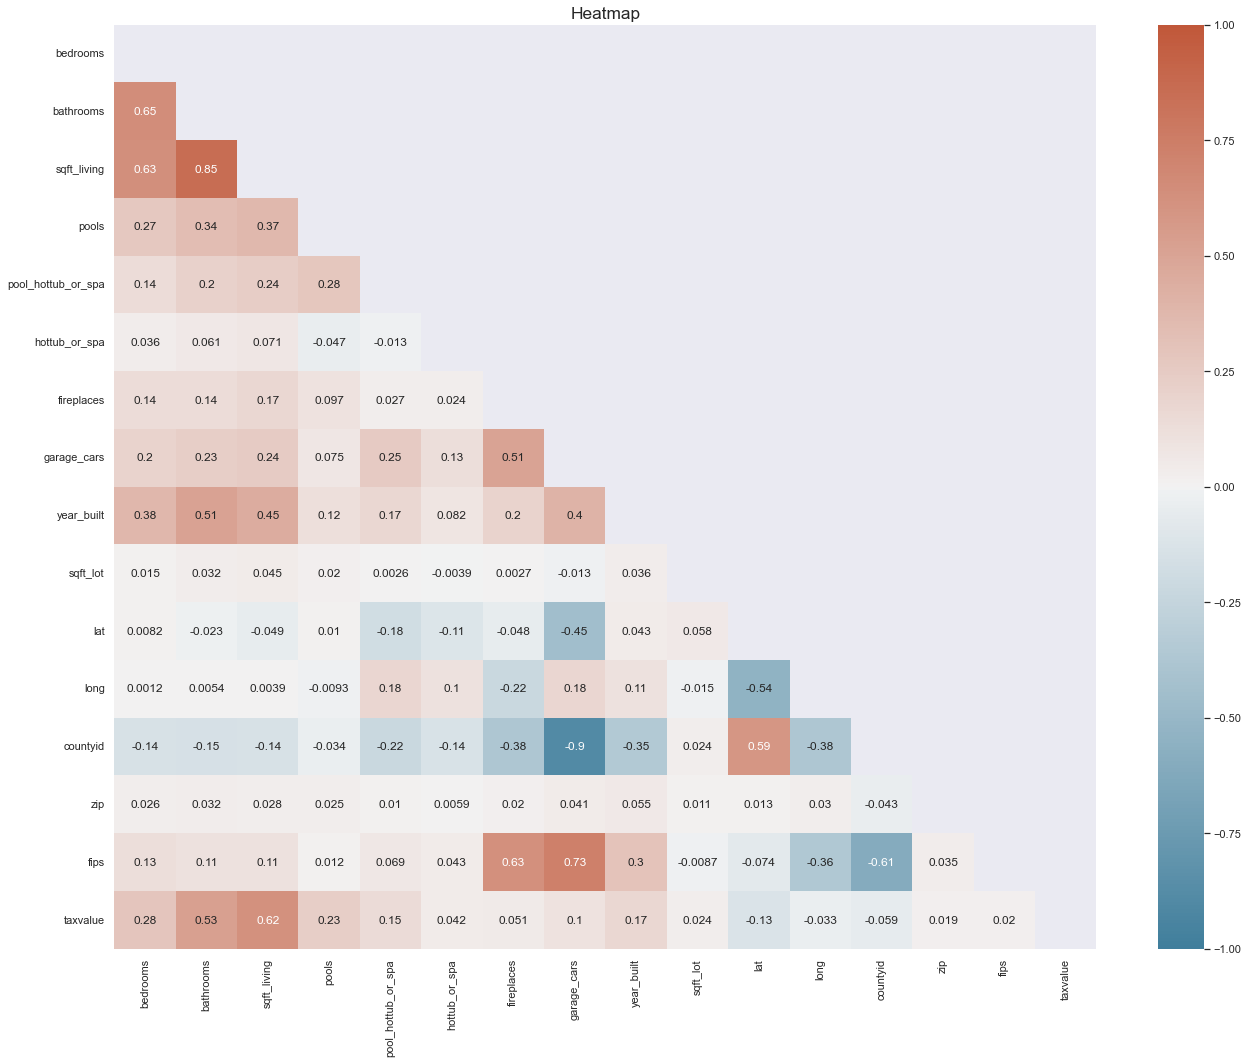

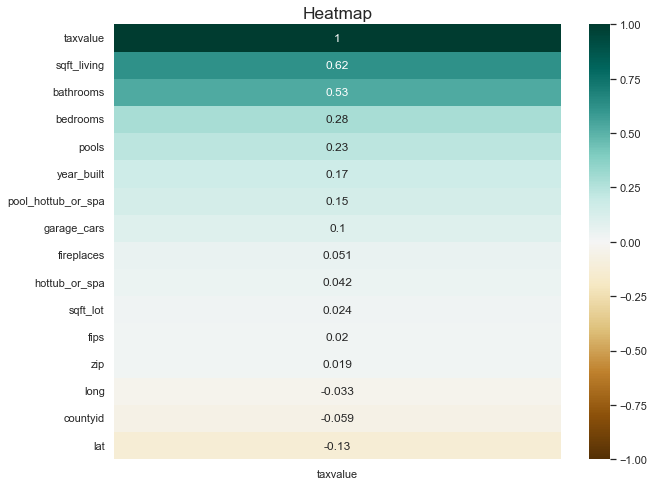

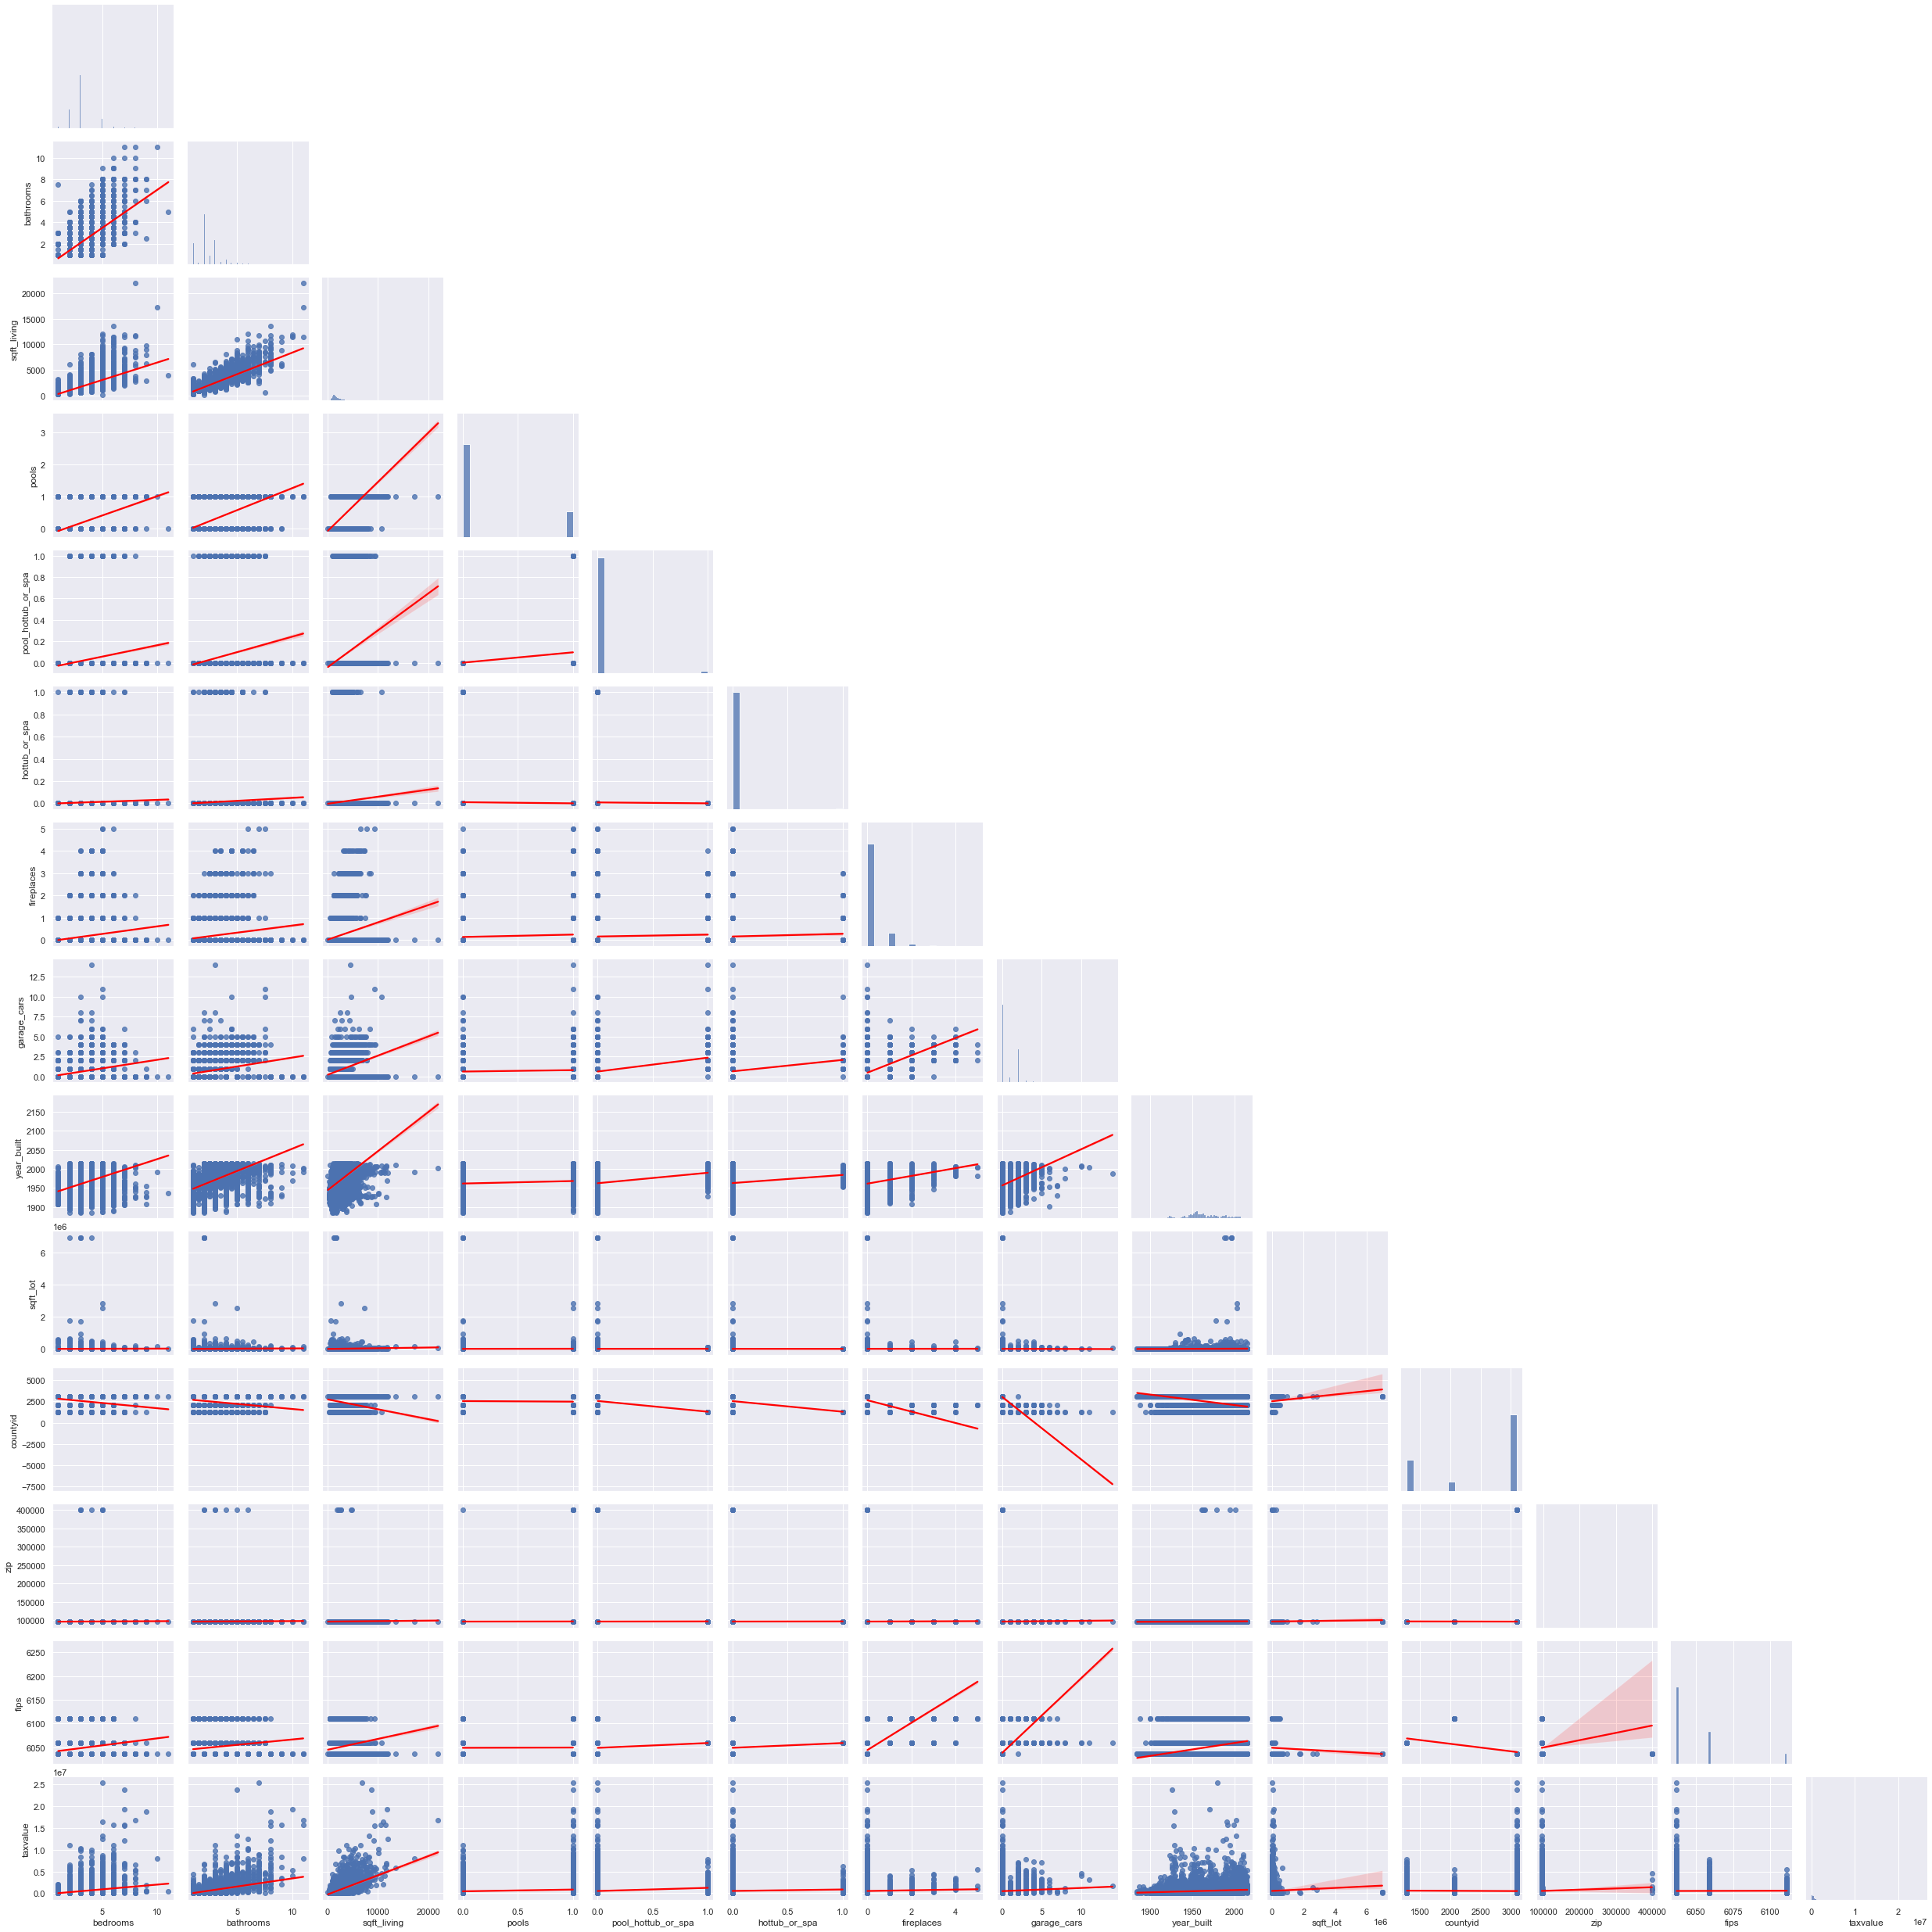

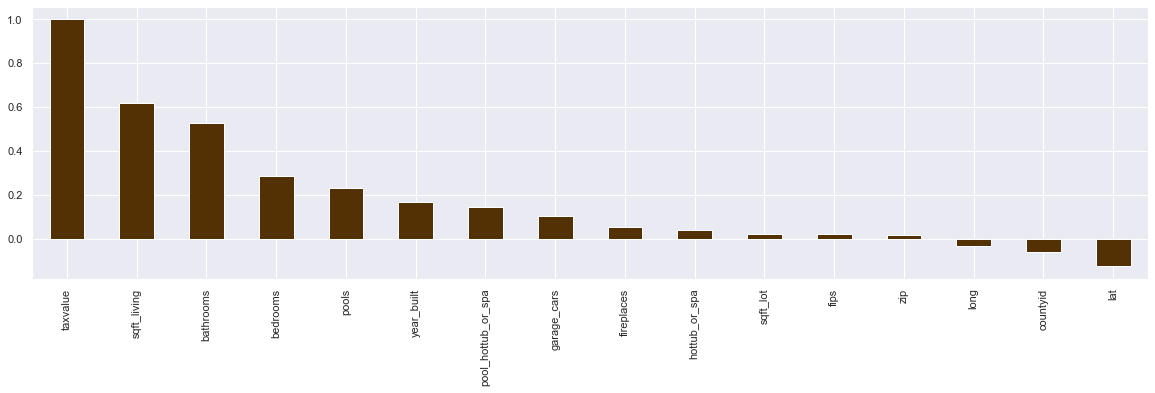

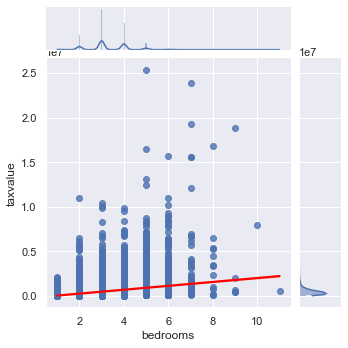

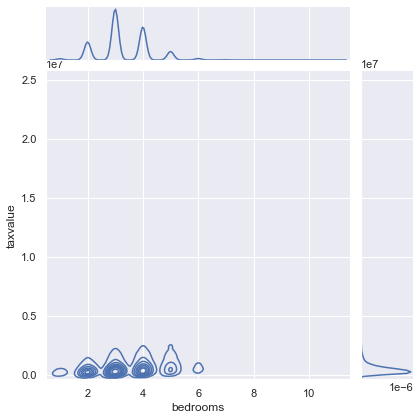

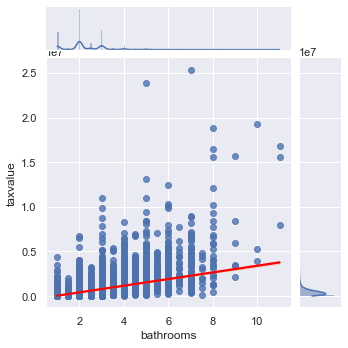

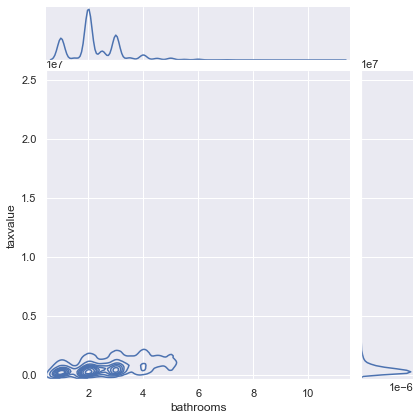

In [27]:
corrstatsgraphs3(train)

In [28]:
train.head()

,bedrooms,bathrooms,sqft_living,pools,pool_hottub_or_spa,hottub_or_spa,fireplaces,garage_cars,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
44983,4.0,3.0,2116.0,0.0,0.0,0.0,0.0,0.0,2005.0,3779.0,34443254.0,-118556609.0,3101.0,96377.0,6037.0,357776.0
43005,3.0,2.0,1177.0,1.0,0.0,0.0,0.0,0.0,1973.0,9270.0,34435112.0,-118485274.0,3101.0,96374.0,6037.0,410538.0
15413,4.0,3.0,2949.0,1.0,0.0,0.0,0.0,0.0,1977.0,21066.0,33964005.0,-118007102.0,3101.0,96173.0,6037.0,524615.0
23491,4.0,4.5,5030.0,1.0,1.0,0.0,0.0,4.0,2003.0,58937.0,33899697.0,-117796382.0,1286.0,97078.0,6059.0,2220280.0
1470,2.0,1.0,815.0,0.0,0.0,0.0,0.0,0.0,1950.0,5615.0,33974924.0,-118109087.0,3101.0,96197.0,6037.0,267338.0


In [29]:
train.hottub_or_spa.value_counts()

0.0    28823
1.0      231
Name: hottub_or_spa, dtype: int64

In [30]:
train.corr().style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,bedrooms,bathrooms,sqft_living,pools,pool_hottub_or_spa,hottub_or_spa,fireplaces,garage_cars,year_built,sqft_lot,lat,long,countyid,zip,fips,taxvalue
bedrooms,1.000000,0.648382,0.634022,0.271690,0.138381,0.036078,0.137382,0.202633,0.378808,0.015191,0.008234,0.001162,-0.142756,0.026154,0.131388,0.283830
bathrooms,0.648382,1.000000,0.852041,0.336146,0.204015,0.061300,0.139745,0.228393,0.513042,0.031561,-0.022961,0.005444,-0.149169,0.032399,0.109045,0.527875
sqft_living,0.634022,0.852041,1.000000,0.372007,0.241781,0.071118,0.168983,0.244345,0.446567,0.044903,-0.049490,0.003949,-0.144934,0.027582,0.109363,0.617669
pools,0.271690,0.336146,0.372007,1.000000,0.278766,-0.046753,0.097153,0.075160,0.117504,0.020178,0.010215,-0.009280,-0.034046,0.024944,0.011673,0.231093
pool_hottub_or_spa,0.138381,0.204015,0.241781,0.278766,1.000000,-0.013033,0.026661,0.252327,0.170483,0.002600,-0.180811,0.179104,-0.224869,0.010266,0.069309,0.145184
hottub_or_spa,0.036078,0.061300,0.071118,-0.046753,-0.013033,1.000000,0.023633,0.129848,0.082397,-0.003854,-0.112635,0.103548,-0.138279,0.005941,0.042620,0.042060
fireplaces,0.137382,0.139745,0.168983,0.097153,0.026661,0.023633,1.000000,0.506057,0.202574,0.002660,-0.048172,-0.223738,-0.380734,0.019706,0.627484,0.051481
garage_cars,0.202633,0.228393,0.244345,0.075160,0.252327,0.129848,0.506057,1.000000,0.404809,-0.012558,-0.449791,0.175086,-0.895366,0.041194,0.732435,0.101456
year_built,0.378808,0.513042,0.446567,0.117504,0.170483,0.082397,0.202574,0.404809,1.000000,0.035804,0.043333,0.107466,-0.352726,0.055010,0.297871,0.165357
sqft_lot,0.015191,0.031561,0.044903,0.020178,0.002600,-0.003854,0.002660,-0.012558,0.035804,1.000000,0.057940,-0.014579,0.024112,0.011458,-0.008681,0.023877


# What is the relationship between sqft living space vs tax value

Text(25, 120, 'r = 0.6177, p = 0.0000')

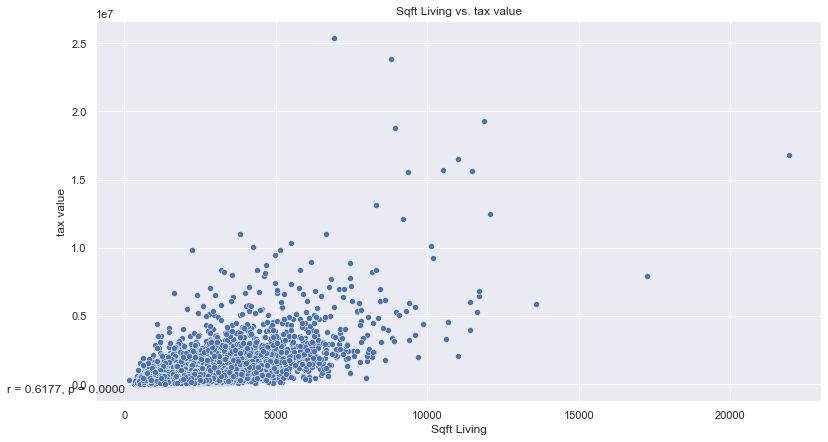

In [31]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(train.sqft_living, train.taxvalue)

sns.scatterplot(data=train, x=train.sqft_living, y=train.taxvalue)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 120, text, va='top', ha='right')

    Seems to be a strong relationship between sqft living space and tax value

# What is the relationship between number of bedrooms vs tax value?

Text(25, 50, 'r = 0.2838, p = 0.0000')

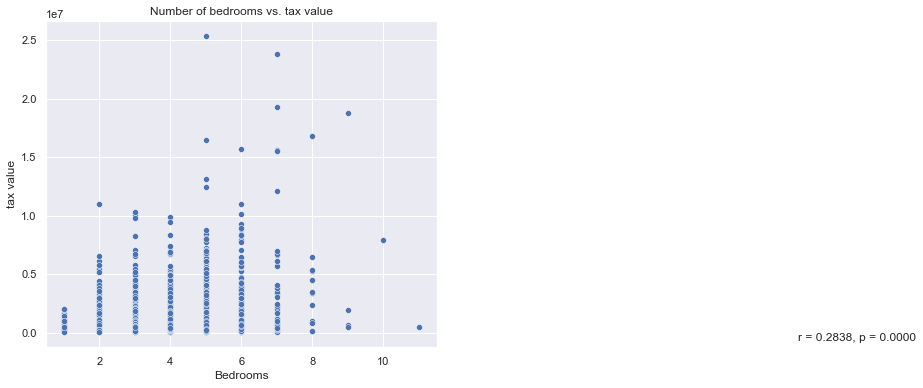

In [32]:
fig, axes = plt.subplots(figsize=(7, 6))

r, p = stats.pearsonr(train.bedrooms, train.taxvalue)

sns.scatterplot(data=train, x=train.bedrooms, y=train.taxvalue)
axes.set(
    xlabel='Bedrooms',
    ylabel='tax value',
    title='Number of bedrooms vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 50, text, va='top', ha='right')

    Seems to be a weak relationship between number of bedrooms and tax value

# What is the relationship between number of bathrooms vs tax value? 

Text(25, 50, 'r = 0.5279, p = 0.0000')

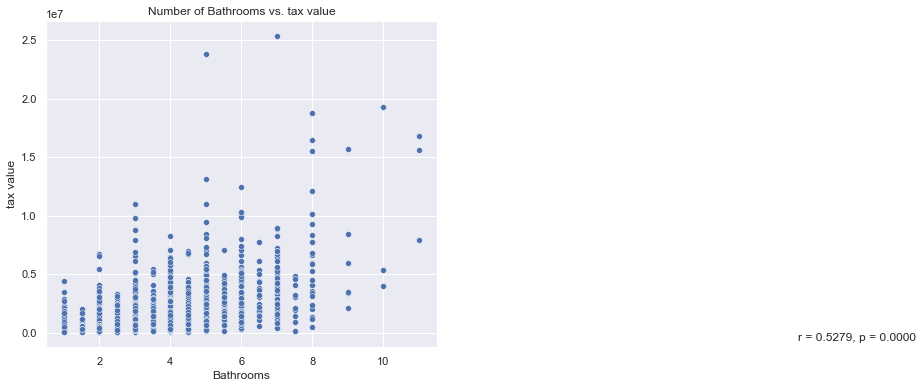

In [33]:
fig, axes = plt.subplots(figsize=(7, 6))

r, p = stats.pearsonr(train.bathrooms, train.taxvalue)

sns.scatterplot(data=train, x=train.bathrooms, y=train.taxvalue)
axes.set(
    xlabel='Bathrooms',
    ylabel='tax value',
    title='Number of Bathrooms vs. tax value',
)
text = f'r = {r:.4f}, p = {p:.4f}'
axes.text(25, 50, text, va='top', ha='right')

    Seems to be a relationship between number of bathrooms and tax value

# What is the relationship between pools with or without hot tubs and spas vs tax value?

[Text(0.5, 0, 'Sqft Living'),
 Text(0, 0.5, 'tax value'),
 Text(0.5, 1.0, 'Sqft Living vs. tax value')]

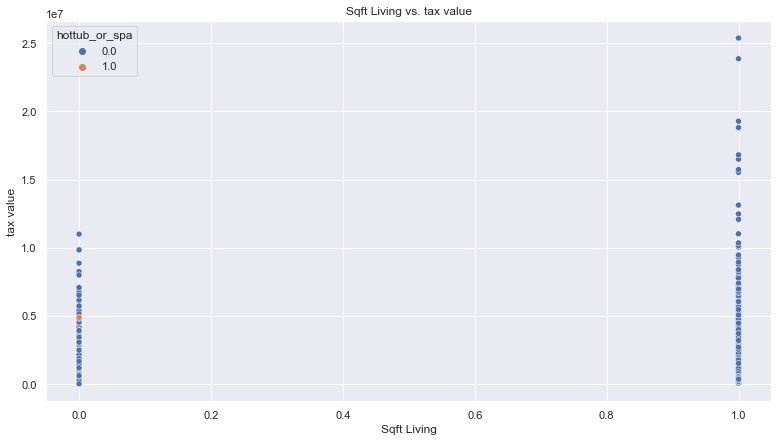

In [34]:
fig, axes = plt.subplots(figsize=(13, 7))

r, p = stats.pearsonr(train.pools, train.taxvalue)

sns.scatterplot(data=train, x=train.pools, y=train.taxvalue, hue=train.hottub_or_spa)
axes.set(
    xlabel='Sqft Living',
    ylabel='tax value',
    title='Sqft Living vs. tax value',
)


    preprocessing 

    baseline 

In [35]:
baseline = eda.copy(deep=True)

In [36]:
baseline =  baseline.drop(columns=['pool_hottub_or_spa', 'lat', 'long'])

In [37]:
baseline.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'pools', 'hottub_or_spa',
       'fireplaces', 'garage_cars', 'year_built', 'sqft_lot', 'countyid',
       'zip', 'fips', 'taxvalue'],
      dtype='object')

In [38]:
baseline.countyid = baseline.countyid.astype('category')
baseline.zip = baseline.zip.astype('category')
baseline.fips = baseline.fips.astype('category')

In [39]:
baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51883 entries, 0 to 51882
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   bedrooms       51883 non-null  float64 
 1   bathrooms      51883 non-null  float64 
 2   sqft_living    51883 non-null  float64 
 3   pools          51883 non-null  float64 
 4   hottub_or_spa  51883 non-null  float64 
 5   fireplaces     51883 non-null  float64 
 6   garage_cars    51883 non-null  float64 
 7   year_built     51883 non-null  float64 
 8   sqft_lot       51883 non-null  float64 
 9   countyid       51883 non-null  category
 10  zip            51883 non-null  category
 11  fips           51883 non-null  category
 12  taxvalue       51883 non-null  float64 
dtypes: category(3), float64(10)
memory usage: 4.2 MB


In [40]:
baseline.head()

,bedrooms,bathrooms,sqft_living,pools,hottub_or_spa,fireplaces,garage_cars,year_built,sqft_lot,countyid,zip,fips,taxvalue
0,4.0,3.5,3100.0,0.0,0.0,0.0,2.0,1998.0,4506.0,1286.0,96978.0,6059.0,1023282.0
1,2.0,1.0,1465.0,0.0,0.0,1.0,1.0,1967.0,12647.0,2061.0,97099.0,6111.0,464000.0
2,3.0,2.0,1243.0,1.0,0.0,0.0,2.0,1962.0,8432.0,1286.0,97078.0,6059.0,564778.0
3,4.0,3.0,2376.0,1.0,0.0,0.0,0.0,1970.0,13038.0,3101.0,96330.0,6037.0,145143.0
4,4.0,3.0,2962.0,1.0,0.0,0.0,0.0,1950.0,63000.0,3101.0,96293.0,6037.0,773303.0


In [41]:
train_and_validate, bs_test = train_test_split(baseline, random_state=123, test_size=.2)
bs_train, bs_validate = train_test_split(train_and_validate, random_state=123, test_size=.3)

In [42]:
dummy_train = pd.get_dummies(bs_train[['countyid', 'zip', 'fips']], drop_first=[True])
dummy_validate = pd.get_dummies(bs_validate[['countyid', 'zip', 'fips']], drop_first=[True])
dummy_test = pd.get_dummies(bs_test[['countyid', 'zip', 'fips']], drop_first=[True])
# merge dummies with orginal dataframe
bs_train = pd.concat([bs_train, dummy_train], axis=1)
bs_validate = pd.concat([bs_validate, dummy_validate], axis=1)
bs_test = pd.concat([bs_test, dummy_test], axis=1)
# drop columns with corresponding dummies
bs_train = bs_train.drop(columns=['countyid', 'zip', 'fips'])
bs_validate = bs_validate.drop(columns=['countyid', 'zip', 'fips'])
bs_test = bs_test.drop(columns=['countyid', 'zip', 'fips'])

In [43]:
def bs_X_y(bs_train, bs_validate, bs_test):

    # drop target data for X_train and assign target data for y_train
    X_train = bs_train.drop(columns=['taxvalue'])
    y_train = bs_train.taxvalue
    # drop target data for X_validate and assign target data for y_validate
    X_validate = bs_validate.drop(columns=['taxvalue'])
    y_validate = bs_validate.taxvalue
    # drop target data for X_test and assign target data for y_test 
    X_test = bs_test.drop(columns=['taxvalue'])
    y_test = bs_test.taxvalue
    
        
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [44]:
X_train, y_train, X_validate, y_validate, X_test, y_test = bs_X_y(bs_train, bs_validate, bs_test)

In [45]:
X_train.head()

,bedrooms,bathrooms,sqft_living,pools,hottub_or_spa,fireplaces,garage_cars,year_built,sqft_lot,countyid_2061.0,...,zip_97323.0,zip_97324.0,zip_97328.0,zip_97329.0,zip_97330.0,zip_97331.0,zip_97344.0,zip_399675.0,fips_6059.0,fips_6111.0
44983,4.0,3.0,2116.0,0.0,0.0,0.0,0.0,2005.0,3779.0,0,...,0,0,0,0,0,0,0,0,0,0
43005,3.0,2.0,1177.0,1.0,0.0,0.0,0.0,1973.0,9270.0,0,...,0,0,0,0,0,0,0,0,0,0
15413,4.0,3.0,2949.0,1.0,0.0,0.0,0.0,1977.0,21066.0,0,...,0,0,0,0,0,0,0,0,0,0
23491,4.0,4.5,5030.0,1.0,0.0,0.0,4.0,2003.0,58937.0,0,...,0,0,0,0,0,0,0,0,1,0
1470,2.0,1.0,815.0,0.0,0.0,0.0,0.0,1950.0,5615.0,0,...,0,0,0,0,0,0,0,0,0,0


    Baseline w/ no feature selection, scaling, and outliers removal

In [46]:
predictions = pd.DataFrame({'actual': validate.taxvalue})

In [47]:
predictions['baseline'] = train.taxvalue.mean()

In [48]:
X_train = train[['sqft_living']]
X_validate = validate[['sqft_living']]
y_train = train.taxvalue

lm = LinearRegression()
lm.fit(X_train, y_train)
predictions['simple_lm'] = lm.predict(X_validate)
lm.score(X_train, y_train)

0.38151558506231076

In [49]:
predictions.head()

,actual,baseline,simple_lm
41380,165413.0,524891.640876,18666.495898
12242,74552.0,524891.640876,535412.085356
1865,147163.0,524891.640876,390617.048721
18048,59596.0,524891.640876,126709.275528
8242,299104.0,524891.640876,271061.513885


In [50]:
m, b = lm.coef_[0], lm.intercept_
print(f'taxvalue = {m:.3f} x sqft_living + {b:.3f}')

taxvalue = 442.798 x sqft_living + -324944.967
